## Metabolic simulation of compartment 3

t = 2000.00 h: : 991it [01:37, 10.14it/s]


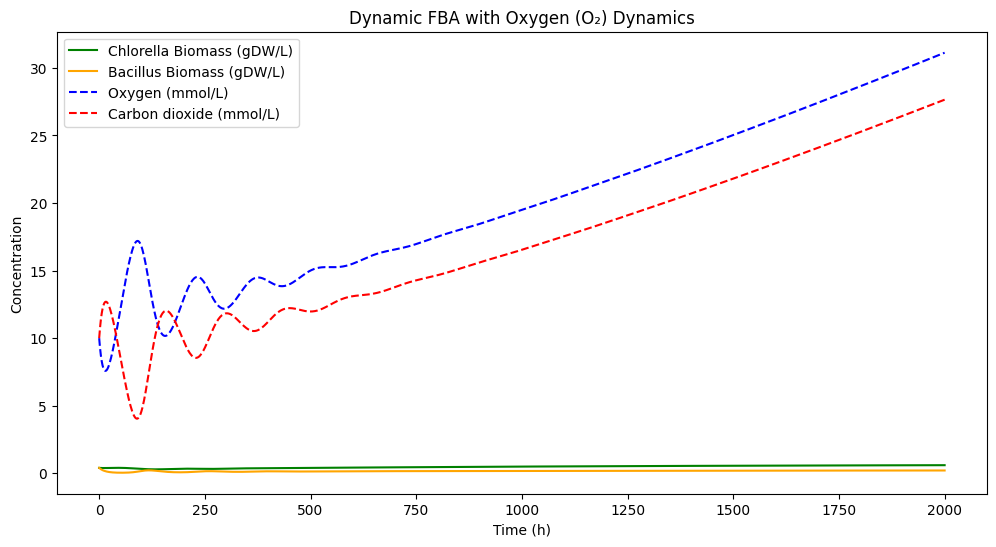

   Time (h)  Chlorella Biomass (gDW/L)  Bacillus Biomass (gDW/L)  \
0  0.000000                   0.400000                  0.400000   
1  2.002002                   0.395632                  0.346639   
2  4.004004                   0.392401                  0.302378   
3  6.006006                   0.390161                  0.264853   
4  8.008008                   0.388773                  0.232653   

   Oxygen (mmol/L)  
0        10.000000  
1         9.279373  
2         8.719844  
3         8.294535  
4         7.983021  


In [1]:
import cobra
import numpy as np
from scipy.integrate import solve_ivp
from tqdm import tqdm
import matplotlib.pyplot as plt

# ================================
# 1. CARGA DE MODELOS
# ================================

chlorella = cobra.io.read_sbml_model("C:/Users/elena/CobraPy-Model-Photosynthesis/Model Chlorella Analysis/Model_iCZ946.xml")  # Ajusta a tu ruta
bacillus = cobra.io.read_sbml_model("iYO844.xml")  # Ajusta a tu ruta

# ================================
# 2. PARÁMETROS DEL SISTEMA
# ================================
# Condiciones iniciales: x1 (Chlorella), x2 (Bacillus), O2
y0 = [0.4, 0.4, 10, 10]  # Biomasa Chlorella, Biomasa Bacillus, Oxígeno (mmol/L)

# Tiempo de simulación
ts = np.linspace(0, 2000, 1000)

# Parámetros de muerte
d_1, d_2 = 0.01, 0.1 # Tasa de muerte (1/h)

# IDs de las reacciones
chlorella_biomass_rxn = 'Biomass_Cvu_auto_DASH_'
bacillus_biomass_rxn = 'BIOMASS_BS_10'
chlorella_o2_exchange = "DM_o2D_LPAREN_u_RPAREN_"
bacillus_o2_exchange = 'EX_o2_e'

# ================================
# 3. BOUNDARIES DINÁMICAS
# ================================   # Michaelis-Menten sencilla
# ================================
# 4. SISTEMA DINÁMICO GENERAL
# ================================
def dynamic_system(t, y):
    """Sistema: x1, x2, O2"""
    x1, x2, O2, CO2 = y
    uptake_o2 = - (1.8* O2 / (1 + O2))
    uptake_co2 = - (0.6 * CO2 / (0.1 + CO2))

    # ------------------
    # Chlorella
    # ------------------
    with chlorella:
        chlorella.reactions.get_by_id("EX_co2_LPAREN_e_RPAREN_").lower_bound = uptake_co2  # Consumo negativo
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]  # tasa de biomasa
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]# flujo real de O2 (+/-)

    # ------------------
    # Bacillus
    # ------------------
    with bacillus:
        bacillus.reactions.get_by_id('EX_o2_e').lower_bound = uptake_o2  # Consumo negativo
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]  # tasa de biomasa
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]  # flujo real de O2 (+/-)
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
    # ------------------
    # Dinámica de biomasa con muerte y competencia
    # ------------------
    dx1_dt =  x1*v1 *CO2*(1 - x1 - x2) - x1*d_1
    dx2_dt =  x2* v2 * O2*(1 - x1 - x2) - x2*d_2
    # ------------------
    # Dinámica del oxígeno: flujo específico * biomasa
    # ------------------
    O2 = flux_o2_chl * x1 + flux_o2_bac * x2
    CO2= flux_co2_chl * x1 + flux_co2_bac * x2       
    # Progreso
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description(f't = {t:.2f} h')

    return [dx1_dt, dx2_dt, O2, CO2]

dynamic_system.pbar = None

# ================================
# 5. EVENTO DE INFESABILIDAD (opcional)
# ================================
def infeasible_event(t, y):
    x1, x2, O2, CO2 = y
    return min(x1, x2) - 1e-3

infeasible_event.terminal = True
infeasible_event.direction = -1

# ================================
# 6. RESOLVER dFBA
# ================================
with tqdm() as pbar:
    dynamic_system.pbar = pbar
    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

# ================================
# 7. PLOTEO
# ================================
plt.figure(figsize=(12, 6))

plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green')
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange')
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue')
plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with Oxygen (O₂) Dynamics')
plt.legend()
plt.show()

# ================================
# 8. RESULTADOS CSV
# ================================
import pandas as pd
df = pd.DataFrame({
    'Time (h)': sol.t,
    'Chlorella Biomass (gDW/L)': sol.y[0],
    'Bacillus Biomass (gDW/L)': sol.y[1],
    'Oxygen (mmol/L)': sol.y[2]
})
df.to_csv('dfba_oxygen_dynamics.csv', index=False)
print(df.head())



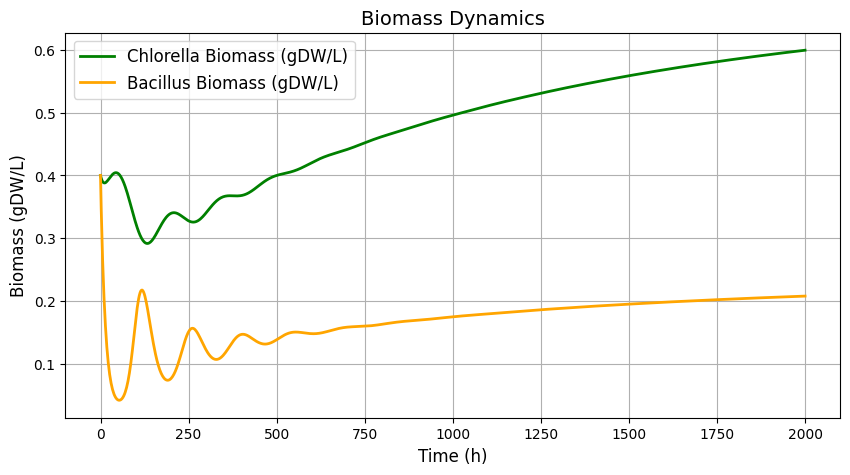

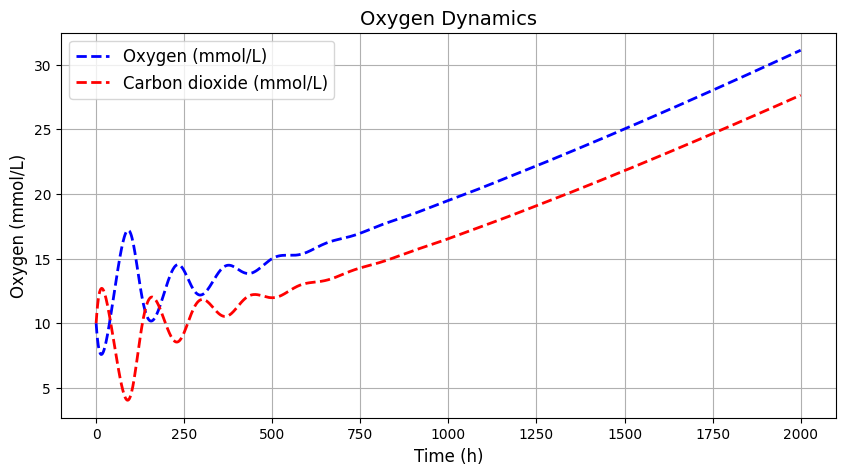

In [2]:
import matplotlib.pyplot as plt

# ================================
# GRAFICO DE BIOMASAS
# ================================
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green', linewidth=2)
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange', linewidth=2)
plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Biomass (gDW/L)', fontsize=12)
plt.title('Biomass Dynamics', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# ================================
# GRAFICO DE OXIGENO
# ================================
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue', linewidth=2)
plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red', linewidth=2)
plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Oxygen (mmol/L)', fontsize=12)
plt.title('Oxygen Dynamics', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [3]:
bacillus.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.0003781,0,0.00%
fe3_e,EX_fe3_e,0.000407,0,0.00%
glc__D_e,EX_glc__D_e,1.7,6,100.00%
k_e,EX_k_e,0.08332,0,0.00%
mg2_e,EX_mg2_e,0.012,0,0.00%
nh4_e,EX_nh4_e,0.945,0,0.00%
o2_e,EX_o2_e,5.706,0,0.00%
pi_e,EX_pi_e,0.1811,0,0.00%
so4_e,EX_so4_e,0.02009,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux


In [4]:
chlorella.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_LPAREN_e_RPAREN_,7.919,1,100.00%
h2o_e,EX_h2o_LPAREN_e_RPAREN_,6.476,0,0.00%
h_e,EX_h_LPAREN_e_RPAREN_,0.008779,0,0.00%
mg2_e,EX_mg2_LPAREN_e_RPAREN_,7.566E-05,0,0.00%
no3_e,EX_no3_LPAREN_e_RPAREN_,0.05167,0,0.00%
o2_e,EX_o2_LPAREN_e_RPAREN_,0.04386,0,0.00%
photonVis_e,EX_photonVis_LPAREN_e_RPAREN_,646.1,0,0.00%
pi_e,EX_pi_LPAREN_e_RPAREN_,0.005733,0,0.00%
so4_e,EX_so4_LPAREN_e_RPAREN_,0.003046,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux


In [5]:
from cobra import Model, Reaction, Metabolite


# Actualizar el rango de flujo de las reacciones de intercambio
def actualizar_reacciones(modelo):
    intercambios = [
        'EX_h_LPAREN_e_RPAREN_', 'EX_h2o_LPAREN_e_RPAREN_', 'EX_pi_LPAREN_e_RPAREN_',
        'EX_nh4_LPAREN_e_RPAREN_', 'EX_no3_LPAREN_e_RPAREN_', 'EX_so4_LPAREN_e_RPAREN_',
        'EX_fe2_LPAREN_e_RPAREN_', 'EX_fe3_LPAREN_e_RPAREN_', 'EX_mg2_LPAREN_e_RPAREN_',
        'EX_na1_LPAREN_e_RPAREN_', 'EX_photonVis_LPAREN_e_RPAREN_', 'EX_o2_LPAREN_e_RPAREN_',
        'EX_co2_LPAREN_e_RPAREN_', 'EX_hco3_LPAREN_e_RPAREN_', 'EX_ac_LPAREN_e_RPAREN_',
        'EX_rib_DASH_D_LPAREN_e_RPAREN_', 'EX_no2_LPAREN_e_RPAREN_', 'EX_his_DASH_L_LPAREN_e_RPAREN_',
        'EX_urea_LPAREN_e_RPAREN_', 'EX_ad_LPAREN_e_RPAREN_', 'EX_gua_LPAREN_e_RPAREN_',
        'EX_ade_LPAREN_e_RPAREN_', 'EX_alltt_LPAREN_e_RPAREN_', 'EX_alltn_LPAREN_e_RPAREN_',
        'EX_hxan_LPAREN_e_RPAREN_', 'EX_orn_LPAREN_e_RPAREN_', 'EX_gln_DASH_L_LPAREN_e_RPAREN_',
        'EX_urate_LPAREN_e_RPAREN_', 'EX_leu_DASH_L_LPAREN_e_RPAREN_', 'EX_arg_DASH_L_LPAREN_e_RPAREN_',
        'EX_so3_LPAREN_e_RPAREN_', 'EX_s_LPAREN_e_RPAREN_', 'EX_selt_LPAREN_e_RPAREN_',
        'EX_etoh_LPAREN_e_RPAREN_', 'EX_for_LPAREN_e_RPAREN_', 'EX_h2_LPAREN_e_RPAREN_',
        'EX_glyclt_LPAREN_e_RPAREN_', 'EX_succ_LPAREN_e_RPAREN_', 'EX_lac_DASH_D_LPAREN_e_RPAREN_',
        'EX_6mpur_LPAREN_e_RPAREN_', 'EX_tgua_LPAREN_e_RPAREN_', 'EX_tega_LPAREN_e_RPAREN_',
        'EX_5flura_LPAREN_e_RPAREN_', 'EX_cital_LPAREN_e_RPAREN_', 'EX_lido_LPAREN_e_RPAREN_',
        'EX_glc_DASH_A_LPAREN_e_RPAREN_', 'EX_btn_LPAREN_e_RPAREN_', 'EX_thm_LPAREN_e_RPAREN_',
        'EX_ncam_LPAREN_e_RPAREN_', 'EX_met_DASH_L_LPAREN_e_RPAREN_', 'EX_trp_DASH_L_LPAREN_e_RPAREN_',
        'EX_gly_LPAREN_e_RPAREN_'
    ]
    for rxn_id in intercambios:
        try:
            rxn = modelo.reactions.get_by_id(rxn_id)
            rxn.lower_bound = -0.5
            rxn.upper_bound = 0.5
            print(f"Rango de flujo actualizado para {rxn_id}")
        except KeyError:
            print(f"Reacción {rxn_id} no encontrada en el modelo.")

actualizar_reacciones(chlorella)



Rango de flujo actualizado para EX_h_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_h2o_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_pi_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_nh4_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_no3_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_so4_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_fe2_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_fe3_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_mg2_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_na1_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_photonVis_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_o2_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_co2_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_hco3_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_ac_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_rib_DASH_D_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_no2_LPAREN_e_RPAREN_
Rango de flujo actualizado para EX_his_

In [6]:
from cobra import Model, Reaction, Metabolite
# Actualizar el rango de flujo de una reacción específica
def actualizar_rango_reaccion(modelo, rxn_id, lower_bound, upper_bound):
    try:
        rxn = modelo.reactions.get_by_id(rxn_id)
        rxn.lower_bound = lower_bound
        rxn.upper_bound = upper_bound
        print(f"Rango de flujo actualizado para {rxn_id}: [{lower_bound}, {upper_bound}]")
    except KeyError:
        print(f"Reacción {rxn_id} no encontrada en el modelo.")

actualizar_rango_reaccion(chlorella, 'EX_photonVis_LPAREN_e_RPAREN_', -1000.0, 1000.0)


Rango de flujo actualizado para EX_photonVis_LPAREN_e_RPAREN_: [-1000.0, 1000.0]


In [7]:
chlorella.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_LPAREN_e_RPAREN_,0.5,2,4.56%
co2_e,EX_co2_LPAREN_e_RPAREN_,0.5,1,2.28%
glc_DASH_A_e,EX_glc_DASH_A_LPAREN_e_RPAREN_,0.5,6,13.69%
gln_DASH_L_e,EX_gln_DASH_L_LPAREN_e_RPAREN_,0.5,5,11.41%
gly_e,EX_gly_LPAREN_e_RPAREN_,0.5,2,4.56%
glyclt_e,EX_glyclt_LPAREN_e_RPAREN_,0.5,2,4.56%
h2o_e,EX_h2o_LPAREN_e_RPAREN_,0.5,0,0.00%
h_e,EX_h_LPAREN_e_RPAREN_,0.5,0,0.00%
hco3_e,EX_hco3_LPAREN_e_RPAREN_,0.5,1,2.28%
his_DASH_L_e,EX_his_DASH_L_LPAREN_e_RPAREN_,0.5,6,13.69%


In [8]:

# Actualizar el rango de flujo de las reacciones de intercambio
def actualizar_reacciones(modelo):
    intercambios = [
        'EX_etha_e', 'EX_drib_e', 'EX_csn_e', 'EX_5mtr_e', 'EX_dtmp_e', 'EX_6pgc_e', 'EX_ctbt_e', 'EX_cu2_e',
        'EX_Larab_e', 'EX_ectoine_e', 'EX_cys__D_e', 'EX_cys__L_e', 'EX_eths_e', 'EX_cyst__L_e', 'EX_Lcyst_e',
        'EX_cytd_e', 'EX_abt__L_e', 'EX_etoh_e', 'EX_dad_2_e', 'EX_dcyt_e', 'EX_fe2_e', 'EX_dextrin_e', 'EX_dha_e',
        'EX_ac_e', 'EX_acac_e', 'EX_fe3_e', 'EX_ferrich_e', 'EX_diact_e', 'EX_djenk_e', 'EX_ferxa_e', 'EX_fol_e',
        'EX_acgam_e', 'EX_acmana_e', 'EX_acnam_e', 'EX_for_e', 'EX_fru_e', 'EX_actn__R_e', 'EX_ade_e', 'EX_adn_e',
        'EX_akg_e', 'EX_ala_B_e', 'EX_ala__D_e', 'EX_ala__L_e', 'EX_ala_L_Thr__L_e', 'EX_ala_L_asp__L_e',
        'EX_ala_L_gln__L_e', 'EX_ala_L_glu__L_e', 'EX_L_alagly_e', 'EX_ala_L_his__L_e', 'EX_ala_L_leu__L_e',
        'EX_g6p_e', 'EX_gal_e', 'EX_galctr__D_e', 'EX_galt_e', 'EX_galur_e', 'EX_gam6p_e', 'EX_gam_e',
        'EX_gbbtn_e', 'EX_glc__D_e', 'EX_glcn__D_e', 'EX_glcr_e', 'EX_glcur_e', 'EX_gln__L_e', 'EX_glu__D_e',
        'EX_alaala_e', 'EX_alltn_e', 'EX_amp_e', 'EX_amylase_e', 'EX_fum_e', 'EX_antim_e', 'EX_g1p_e',
        'EX_glu__L_e', 'EX_arab__D_e', 'EX_arab__L_e', 'EX_arbt_e', 'EX_arg__L_e', 'EX_argp_e', 'EX_arsenb_e',
        'EX_arsna_e', 'EX_arsni2_e', 'EX_asn__L_e', 'EX_asp__L_e', 'EX_bilea_e', 'EX_btd_RR_e', 'EX_glx_e',
        'EX_buts_e', 'EX_ca2_e', 'EX_cbl2_e', 'EX_pur_e', 'EX_pyr_e', 'EX_cd2_e', 'EX_gly_asn__L_e',
        'EX_cellb_e', 'EX_cgly_e', 'EX_raffin_e', 'EX_rib__D_e', 'EX_gly_asp__L_e', 'EX_ribflv_e', 'EX_chitob_e',
        'EX_gly_e', 'EX_chol_e', 'EX_rmn_e', 'EX_gly_gln__L_e', 'EX_chols_e', 'EX_chor_e', 'EX_cit_e',
        'EX_salcn_e', 'EX_gly_glu__L_e', 'EX_sbt__D_e', 'EX_ser__D_e', 'EX_citr__L_e', 'EX_cmp_e',
        'EX_ser__L_e', 'EX_gly_met__L_e', 'EX_so4_e', 'EX_spmd_e', 'EX_co2_e', 'EX_cobalt2_e', 'EX_crn_e',
        'EX_cro4_e', 'EX_srb__L_e', 'EX_starch_e', 'EX_subtilisin_e', 'EX_succ_e', 'EX_sucr_e',
        'EX_gly_pro__L_e', 'EX_sula_e', 'EX_taur_e', 'EX_glyb_e', 'EX_thiog_e', 'EX_glyc3p_e', 'EX_glyc_e',
        'EX_glyclt_e', 'EX_glycogen_e', 'EX_gmp_e', 'EX_gsn_e', 'EX_thr__L_e', 'EX_gthox_e', 'EX_thym_e',
        'EX_gthrd_e', 'EX_thymd_e', 'EX_gua_e', 'EX_tmp_e', 'EX_tre_e', 'EX_trp__L_e', 'EX_h2o2_e', 'EX_tyr__L_e',
        'EX_h2o_e', 'EX_ump_e', 'EX_ura_e', 'EX_h_e', 'EX_urate_e', 'EX_hexs_e', 'EX_urea_e', 'EX_uri_e',
        'EX_val__L_e', 'EX_xan_e', 'EX_xtsn_e', 'EX_xyl__D_e', 'EX_zn2_e', 'EX_hg2_e', 'EX_his__L_e',
        'EX_hqn_e', 'EX_hxan_e', 'EX_icit_e', 'EX_ile__L_e', 'EX_inost_e', 'EX_ins_e', 'EX_istnt_e',
        'EX_k_e', 'EX_lac__L_e', 'EX_lanth_e', 'EX_lcts_e', 'EX_leu__L_e', 'EX_lipt_e', 'EX_lys__L_e',
        'EX_madg_e', 'EX_mal__D_e', 'EX_mal__L_e', 'EX_malt_e', 'EX_malttr_e', 'EX_man1p_e', 'EX_man6p_e',
        'EX_man_e', 'EX_3ump_e', 'EX_mbdg_e', 'EX_melib_e', 'EX_meoh_e', 'EX_met__D_e', 'EX_met_L_ala__L_e',
        'EX_met__L_e', 'EX_metox__R_e', 'EX_metox_e', 'EX_mg2_e', 'EX_mn2_e', 'EX_mnl_e', 'EX_mobd_e',
        'EX_mops_e', 'EX_mso3_e', 'EX_na1_e', 'EX_nac_e', 'EX_nh4_e', 'EX_ni2_e', 'EX_no2_e', 'EX_no3_e',
        'EX_o2_e', 'EX_orn__L_e', 'EX_pala_e', 'EX_4abut_e', 'EX_pep_e', 'EX_phe__L_e', 'EX_pi_e',
        'EX_pnto__R_e', 'EX_ppa_e', 'EX_ppi_e', 'EX_pro__L_e', 'EX_prolb_e', 'EX_pser__D_e', 'EX_pser__L_e'
    ]
    for rxn_id in intercambios:
        try:
            rxn = modelo.reactions.get_by_id(rxn_id)
            rxn.lower_bound = -0.8
            rxn.upper_bound = 0.8
            print(f"Rango de flujo actualizado para {rxn_id}")
        except KeyError:
            print(f"Reacción {rxn_id} no encontrada en el modelo.")

actualizar_reacciones(bacillus)

Rango de flujo actualizado para EX_etha_e
Rango de flujo actualizado para EX_drib_e
Rango de flujo actualizado para EX_csn_e
Rango de flujo actualizado para EX_5mtr_e
Rango de flujo actualizado para EX_dtmp_e
Rango de flujo actualizado para EX_6pgc_e
Rango de flujo actualizado para EX_ctbt_e
Rango de flujo actualizado para EX_cu2_e
Rango de flujo actualizado para EX_Larab_e
Rango de flujo actualizado para EX_ectoine_e
Rango de flujo actualizado para EX_cys__D_e
Rango de flujo actualizado para EX_cys__L_e
Rango de flujo actualizado para EX_eths_e
Rango de flujo actualizado para EX_cyst__L_e
Rango de flujo actualizado para EX_Lcyst_e
Rango de flujo actualizado para EX_cytd_e
Rango de flujo actualizado para EX_abt__L_e
Rango de flujo actualizado para EX_etoh_e
Rango de flujo actualizado para EX_dad_2_e
Rango de flujo actualizado para EX_dcyt_e
Rango de flujo actualizado para EX_fe2_e
Rango de flujo actualizado para EX_dextrin_e
Rango de flujo actualizado para EX_dha_e
Rango de flujo actua

In [9]:
bacillus.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
3ump_e,EX_3ump_e,0.3656,9,4.35%
acmana_e,EX_acmana_e,0.01338,8,0.14%
acnam_e,EX_acnam_e,0.8,11,11.65%
adn_e,EX_adn_e,0.8,10,10.59%
akg_e,EX_akg_e,0.8,5,5.29%
amp_e,EX_amp_e,0.6413,10,8.49%
argp_e,EX_argp_e,0.007901,6,0.06%
ca2_e,EX_ca2_e,0.0001312,0,0.00%
chor_e,EX_chor_e,0.8,10,10.59%
cmp_e,EX_cmp_e,0.002357,9,0.03%


In [10]:
chlorella_metabolites = ['DM_udg_LPAREN_m_RPAREN_', 'EX_ac_LPAREN_e_RPAREN_', 'EX_ade_LPAREN_e_RPAREN_', 'EX_alltt_LPAREN_e_RPAREN_',
                         'EX_gly_LPAREN_e_RPAREN_', 'EX_gua_LPAREN_e_RPAREN_', 'EX_h2_LPAREN_e_RPAREN_', 'EX_h2o_LPAREN_e_RPAREN_',
                         'EX_h_LPAREN_e_RPAREN_', 'EX_nh4_LPAREN_e_RPAREN_', 'EX_urate_LPAREN_e_RPAREN_', 'EX_urea_LPAREN_e_RPAREN_']

bacillus_metabolites = ['EX_6pgc_e', 'EX_ac_e', 'EX_acac_e', 'EX_btd_RR_e', 'EX_for_e', 'EX_fum_e', 'EX_gam6p_e',
                        'EX_gly_e', 'EX_gsn_e', 'EX_gthox_e', 'EX_h_e', 'EX_icit_e', 'EX_lac__L_e', 'EX_man6p_e', 'EX_nh4_e',
                        'EX_pi_e', 'EX_pnto__R_e', 'EX_pser__L_e', 'EX_pyr_e', 'EX_srb__L_e', 'EX_succ_e', 'EX_thym_e',
                        'EX_tyr__L_e', 'EX_ura_e', 'EX_xan_e', 'EX_xtsn_e']

# Mapeo de metabolitos compartidos
metabolite_mapping = {
    'EX_ac_LPAREN_e_RPAREN_': 'EX_ac_e',
    'EX_h2o_LPAREN_e_RPAREN_': 'EX_h2o_e',
    'EX_h_LPAREN_e_RPAREN_': 'EX_h_e',
    'EX_nh4_LPAREN_e_RPAREN_': 'EX_nh4_e',
    'EX_gly_LPAREN_e_RPAREN_': 'EX_gly_e',
}



t = 5000.00 h: : 2411it [04:09,  9.68it/s]


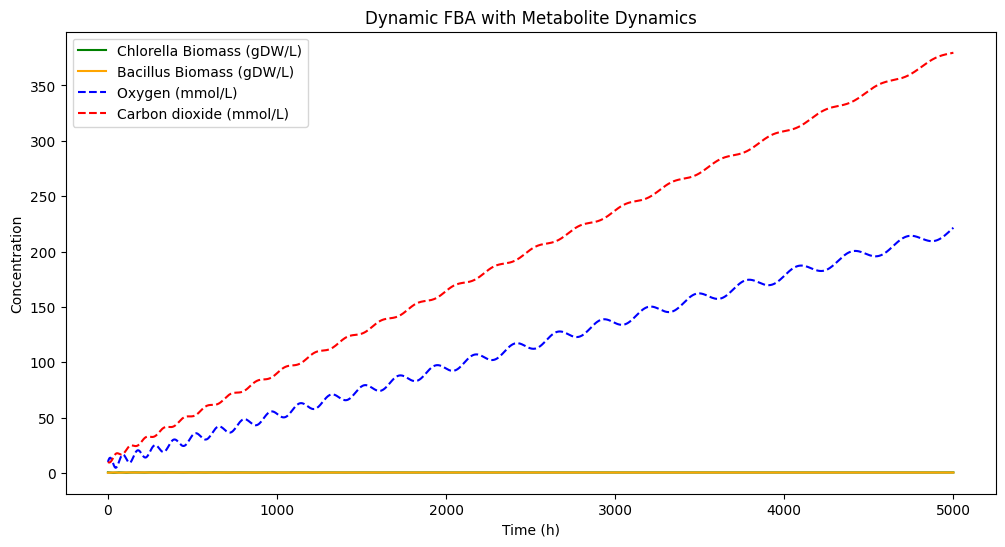

In [11]:
from collections import defaultdict
fluxes= defaultdict(list)
total_mets= chlorella_metabolites + bacillus_metabolites
# ================================
# 2. PARÁMETROS DEL SISTEMA
# ================================
# Condiciones iniciales: x1 (Chlorella), x2 (Bacillus), O2
y0 = [0.6, 0.3, 10, 10, 1, 1, 1, 1, 1]  # Biomasa Chlorella, Biomasa Bacillus, Oxígeno (mmol/L)

# Tiempo de simulación
ts = np.linspace(0, 5000, 1000)

# Parámetros de muerte
d_1, d_2 = 0.08, 0.06 # Tasa de muerte (1/h)

# IDs de las reacciones
chlorella_biomass_rxn = 'Biomass_Cvu_auto_DASH_'
bacillus_biomass_rxn = 'BIOMASS_BS_10'
chlorella_o2_exchange = "DM_o2D_LPAREN_u_RPAREN_"
bacillus_o2_exchange = 'EX_o2_e'

# ================================
# 3. BOUNDARIES DINÁMICAS
# ================================   # Michaelis-Menten sencilla
# ================================
# 4. SISTEMA DINÁMICO GENERAL
# ================================
def dynamic_system(t, y):
    """Sistema: x1, x2, O2"""
    x1, x2, O2, CO2, AC, H2O, H, NH4, GLY = y
    uptake_o2 = - (1.8* O2 / (1 + O2))
    uptake_co2 = - (0.6 * CO2 / (0.1 + CO2))

    # ------------------
    # Chlorella
    # ------------------
    with chlorella:
        chlorella.reactions.get_by_id("EX_co2_LPAREN_e_RPAREN_").lower_bound = uptake_co2  # Consumo negativo
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]  # tasa de biomasa
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]

    # ------------------
    # Bacillus
    # ------------------
    with bacillus:
        bacillus.reactions.get_by_id('EX_o2_e').lower_bound = uptake_o2  # Consumo negativo
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]  # tasa de biomasa
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]  # flujo real de O2 (+/-)
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
    # ------------------
    # Dinámica de biomasa con muerte y competencia
    # ------------------
    dx1_dt =  x1*v1 *CO2*(1 - x1 - x2) - x1*d_1
    dx2_dt =  x2*v2* O2*(1 - x1 - x2) - x2*d_2
    # ------------------
  #  print("flujo biomasa chlorella", v1)
  #  print("flujo biomasa bacillus", v2)
  #  print("biomasa chlorella", x1)
  #  print("biomasa bacillus", x2)
    # Dinámica del oxígeno: flujo específico * biomasa
    # ------------------
    O2 = flux_o2_chl * x1 + flux_o2_bac * x2
    CO2= flux_co2_chl * x1 + flux_co2_bac * x2  
    for met in total_mets:
        met_v2 = met.split("_")[1]
        met_v3 = met_v2[0:len(met_v2)]
        if met in chlorella_metabolites:
            flux_chl = sol_chl.fluxes.get(met, 0) * x1
            fluxes[met_v3].append(flux_chl)
        elif met in bacillus_metabolites:
            flux_bac = sol_bac.fluxes.get(met, 0) * x2
            fluxes[met_v3].append(flux_bac)
    AC = sol_chl.fluxes['EX_ac_LPAREN_e_RPAREN_']*x1 + sol_bac.fluxes['EX_ac_e']
    H2O = sol_chl.fluxes['EX_h2o_LPAREN_e_RPAREN_']*x1 + sol_bac.fluxes['EX_h2o_e']
    H = sol_chl.fluxes['EX_h_LPAREN_e_RPAREN_']*x1 + sol_bac.fluxes['EX_h_e']
    NH4 = sol_chl.fluxes['EX_nh4_LPAREN_e_RPAREN_']*x1 + sol_bac.fluxes['EX_nh4_e']
    GLY = sol_chl.fluxes['EX_gly_LPAREN_e_RPAREN_']*x1 + sol_bac.fluxes['EX_gly_e']
 #   print("flujo O2 chlorella", flux_o2_chl)
  #  print("flujo O2 bacillus", flux_o2_bac)
    # Progreso
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description(f't = {t:.2f} h')

    return [dx1_dt, dx2_dt, O2, CO2, AC, H2O, H, NH4, GLY]

dynamic_system.pbar = None

# ================================
# 5. EVENTO DE INFESABILIDAD (opcional)
# ================================
def infeasible_event(t, y):
    x1, x2, O2, CO2, AC, H2O, H, NH4, GLY = y
    return min(x1, x2) - 1e-3

infeasible_event.terminal = True
infeasible_event.direction = -1

# ================================
# 6. RESOLVER dFBA
# ================================
with tqdm() as pbar:
    dynamic_system.pbar = pbar
    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

# ================================
# 7. PLOTEO
# ================================
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green')
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange')
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue')
plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red')
#for met in fluxes:
   # plt.plot(sol.t, fluxes[met], label=f'{met}', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with Metabolite Dynamics')
plt.legend()
plt.show()





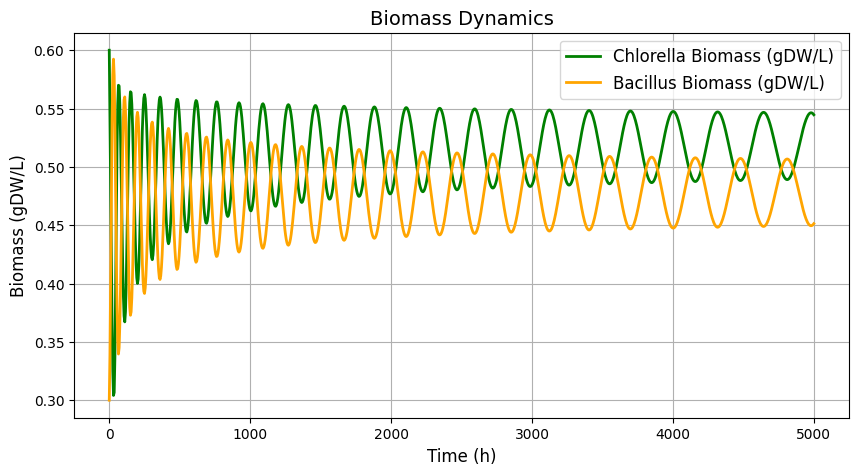

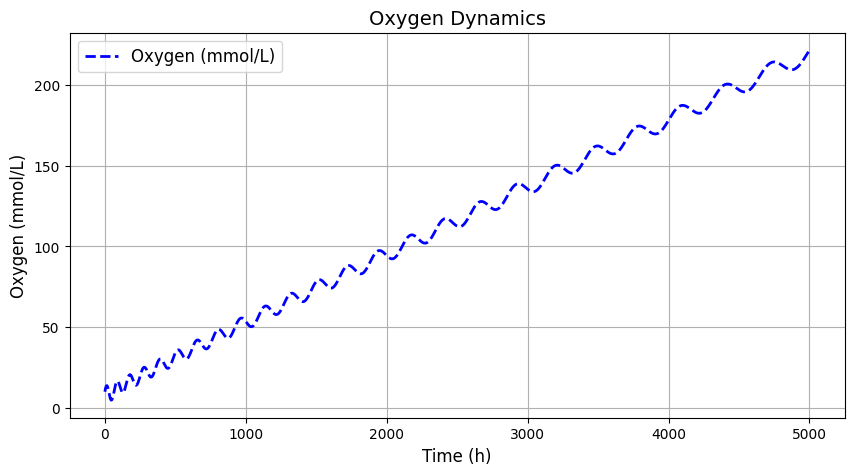

In [12]:
import matplotlib.pyplot as plt

# ================================
# GRAFICO DE BIOMASAS
# ================================
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green', linewidth=2)
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange', linewidth=2)
plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Biomass (gDW/L)', fontsize=12)
plt.title('Biomass Dynamics', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# ================================
# GRAFICO DE OXIGENO
# ================================
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue', linewidth=2)
#plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red', linewidth=2)
plt.xlabel('Time (h)', fontsize=12)
plt.ylabel('Oxygen (mmol/L)', fontsize=12)
plt.title('Oxygen Dynamics', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [26]:
metabolitos_chlorella = {met: [] for met in ["EX_ade_LPAREN_e_RPAREN_", "EX_arg_DASH_L_LPAREN_e_RPAREN_", "EX_gua_LPAREN_e_RPAREN_", "EX_urea_LPAREN_e_RPAREN_", "DM_o2D_LPAREN_u_RPAREN_"]}
metabolitos_bacillus = {met: [] for met in [
    "EX_6pgc_e", "EX_ac_e", "EX_acac_e", "EX_btd_RR_e",
    "EX_for_e", "EX_fum_e", "EX_gam6p_e", "EX_gly_e", "EX_gsn_e", 
    "EX_gthox_e", "EX_h_e", "EX_icit_e", "EX_lac__L_e", "EX_man6p_e", 
    "EX_pi_e", "EX_pnto__R_e", "EX_pser__L_e", "EX_pyr_e", 
    "EX_srb__L_e", "EX_succ_e", "EX_thym_e", "EX_tyr__L_e", 
    "EX_ura_e", "EX_xan_e", "EX_xtsn_e", ]}
growth_rates= {"chlorella": [], "bacillus": [], "O2":[], "CO2": []}
metabolitos_fluxes = {met: [] for met in ["EX_ade_LPAREN_e_RPAREN_", "EX_arg_DASH_L_LPAREN_e_RPAREN_", "EX_gua_LPAREN_e_RPAREN_", "EX_urea_LPAREN_e_RPAREN_", "DM_o2D_LPAREN_u_RPAREN_", "O2", "CO2", "NH4",  "EX_6pgc_e", "EX_ac_e", "EX_acac_e", "EX_btd_RR_e",
    "EX_for_e", "EX_fum_e", "EX_gam6p_e", "EX_gly_e", "EX_gsn_e", 
    "EX_gthox_e", "EX_h_e", "EX_icit_e", "EX_lac__L_e", "EX_man6p_e", 
    "EX_pi_e", "EX_pnto__R_e", "EX_pser__L_e", "EX_pyr_e", 
    "EX_srb__L_e", "EX_succ_e", "EX_thym_e", "EX_tyr__L_e", 
    "EX_ura_e", "EX_xan_e", "EX_xtsn_e", ]}
metabolitos_categories = {met: [] for met in ["NH4", "Azúcares", "Fuentes_C", "Aminoacidos", "Protones", "Acidos orgánicos", "Otros nutrientes", "fosfato"]}
metabolitos_categories_fluxes= {met: [] for met in ["NH4", "Azúcares", "Fuentes_C", "Aminoacidos", "Protones", "Acidos orgánicos", "Otros nutrientes", "fosfato"]}


t = 1000.00 h: : 421it [00:21, 19.82it/s]


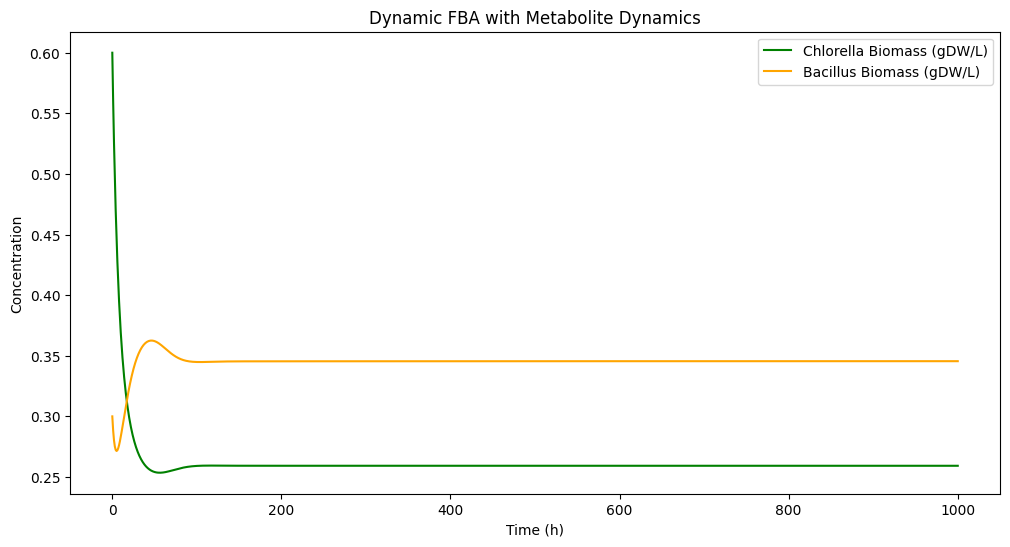

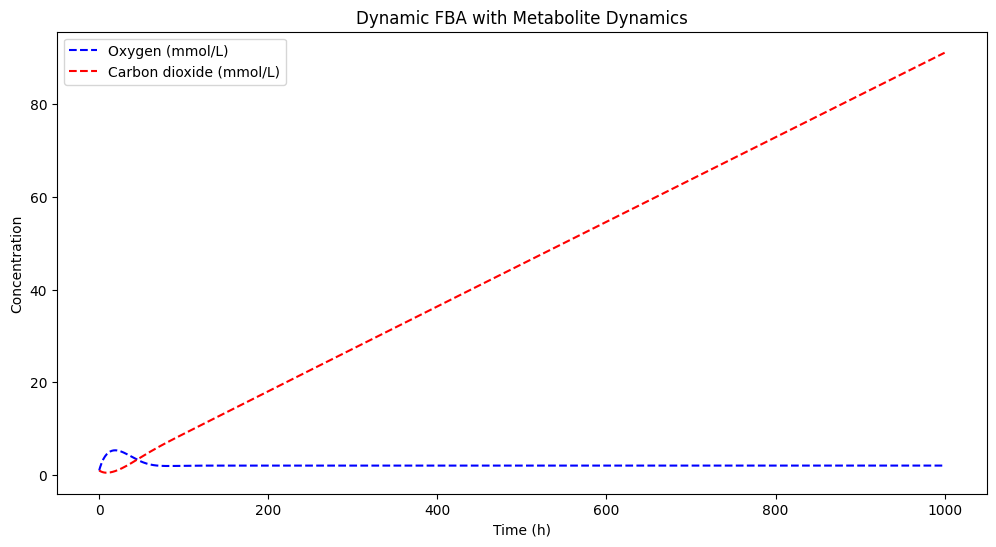

In [27]:
from collections import defaultdict
fluxes= defaultdict(list)
time = []
total_mets= chlorella_metabolites + bacillus_metabolites
# ================================
# 2. PARÁMETROS DEL SISTEMA
# ================================
# Condiciones iniciales: x1 (Chlorella), x2 (Bacillus), O2
y0 = [0.6, 0.3, 1, 1, 0.8, 0,0,0,0,0,0,0]  # Biomasa Chlorella, Biomasa Bacillus, Oxígeno (mmol/L)

# Tiempo de simulación
ts = np.linspace(0, 1000, 1000)

# Parámetros de muerte
d_1, d_2 = 0.08, 0.06 # Tasa de muerte (1/h)

# IDs de las reacciones
chlorella_biomass_rxn = 'Biomass_Cvu_auto_DASH_'
bacillus_biomass_rxn = 'BIOMASS_BS_10'
chlorella_o2_exchange = "DM_o2D_LPAREN_u_RPAREN_"
bacillus_o2_exchange = 'EX_o2_e'

# ================================
# 3. BOUNDARIES DINÁMICAS
# ================================   # Michaelis-Menten sencilla
# ================================
# 4. SISTEMA DINÁMICO GENERAL
# ================================
def dynamic_system(t, y):
    """Sistema: x1, x2, O2"""
    x1, x2, O2, CO2, NH4, Azucares, Fuentes_C, Aminoacidos, Protones, Ácidos_organicos, Other_nutrients, phosphate   = y
    uptake_o2 = - (1.8* O2 / (1 + O2))
    uptake_co2 = - (0.6 * CO2 / (0.1 + CO2))

    # ------------------
    # Chlorella
    # ------------------
    with chlorella:
        chlorella.reactions.get_by_id("EX_co2_LPAREN_e_RPAREN_").upper_bound = 1000
        chlorella.reactions.get_by_id("EX_co2_LPAREN_e_RPAREN_").lower_bound = uptake_co2
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]  # tasa de biomasa
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]
        flux_nh4_chl = sol_chl.fluxes["EX_nh4_LPAREN_e_RPAREN_"]
        growth_rates["chlorella"].append(v1)
    # ------------------
    # Bacillus
    # ------------------
    with bacillus:
        bacillus.reactions.get_by_id('EX_o2_e').upper_bound = 1000
        bacillus.reactions.get_by_id('EX_o2_e').lower_bound = uptake_o2
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]  # tasa de biomasa
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]  # flujo real de O2 (+/-)
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
        flux_nh4_bac = sol_bac.fluxes["EX_nh4_e"]
        growth_rates["bacillus"].append(v2)
    # ------------------
    # Dinámica de biomasa con muerte y competencia
    # ------------------
    #dx1_dt =  x1*v1*CO2*(1 - x1 - x2) - x1*d_1
    #dx2_dt =  x2*v2* O2*(1 - x1 - x2) - x2*d_2
    dx1_dt =  v1*(1 - x1 - x2)- x1*d_1
    dx2_dt =  v2*(1 - x1 - x2)- x2*d_2
    # ------------------
    # Dinámica del oxígeno: flujo específico * biomasa
    # ------------------
    O2 = flux_o2_chl * x1 + flux_o2_bac * x2  -0.03
    CO2= flux_co2_chl * x1 + flux_co2_bac * x2  -0.03 


    
    NH4 = flux_nh4_chl * x1 + flux_nh4_bac * x2 
    Azucares = sol_bac.fluxes["EX_6pgc_e"]*x2 + sol_bac.fluxes["EX_gam6p_e"]*x2 + sol_bac.fluxes["EX_man6p_e"]*x2 + sol_bac.fluxes["EX_srb__L_e"]*x2
    Fuentes_C= sol_bac.fluxes["EX_ac_e"]*x2 + sol_bac.fluxes["EX_acac_e"]*x2 + sol_bac.fluxes["EX_btd_RR_e"]*x2 + sol_bac.fluxes["EX_for_e"]*x2 + sol_bac.fluxes["EX_lac__L_e"]*x2 + sol_bac.fluxes["EX_pyr_e"]*x2 + sol_bac.fluxes["EX_succ_e"]*x2
    Aminoacidos = sol_chl.fluxes["EX_arg_DASH_L_LPAREN_e_RPAREN_"]*x1 + sol_bac.fluxes["EX_gly_e"]*x2 + sol_bac.fluxes["EX_pser__L_e"]*x2 + sol_bac.fluxes["EX_tyr__L_e"]*x2 
    Protones= sol_bac.fluxes["EX_h_e"]*x2
    Ácidos_organicos= sol_bac.fluxes["EX_pnto__R_e"]*x2 
    Other_nutrients= sol_chl.fluxes["EX_ade_LPAREN_e_RPAREN_"]*x1 + sol_chl.fluxes["EX_gua_LPAREN_e_RPAREN_"]*x1 +sol_bac.fluxes["EX_gsn_e"]*x2 + sol_bac.fluxes["EX_gthox_e"]*x2 + sol_bac.fluxes["EX_thym_e"]*x2 + sol_bac.fluxes["EX_ura_e"]*x2 +sol_bac.fluxes["EX_xan_e"]*x2 + sol_bac.fluxes["EX_xtsn_e"]*x2
    phosphate= sol_bac.fluxes["EX_pi_e"]*x2

    growth_rates["O2"].append(flux_o2_chl + flux_o2_bac)
    growth_rates["CO2"].append(flux_co2_bac + flux_co2_chl)

    
    metabolitos_categories_fluxes["NH4"].append(flux_nh4_chl + flux_nh4_bac)
    metabolitos_categories_fluxes["Azúcares"].append(sol_bac.fluxes["EX_6pgc_e"] + sol_bac.fluxes["EX_gam6p_e"] + sol_bac.fluxes["EX_man6p_e"] + sol_bac.fluxes["EX_srb__L_e"])
    metabolitos_categories_fluxes["Fuentes_C"].append(sol_bac.fluxes["EX_ac_e"] + sol_bac.fluxes["EX_acac_e"] + sol_bac.fluxes["EX_btd_RR_e"] + sol_bac.fluxes["EX_for_e"] + sol_bac.fluxes["EX_lac__L_e"] + sol_bac.fluxes["EX_pyr_e"] + sol_bac.fluxes["EX_succ_e"])
    metabolitos_categories_fluxes["Aminoacidos"].append(sol_chl.fluxes["EX_arg_DASH_L_LPAREN_e_RPAREN_"] + sol_bac.fluxes["EX_gly_e"] + sol_bac.fluxes["EX_pser__L_e"] + sol_bac.fluxes["EX_tyr__L_e"])
    metabolitos_categories_fluxes["Protones"].append(sol_bac.fluxes["EX_h_e"])
    metabolitos_categories_fluxes["Acidos orgánicos"].append(sol_bac.fluxes["EX_pnto__R_e"])
    metabolitos_categories_fluxes["Otros nutrientes"].append(sol_chl.fluxes["EX_ade_LPAREN_e_RPAREN_"] + sol_chl.fluxes["EX_gua_LPAREN_e_RPAREN_"] +sol_bac.fluxes["EX_gsn_e"] + sol_bac.fluxes["EX_gthox_e"] + sol_bac.fluxes["EX_thym_e"] + sol_bac.fluxes["EX_ura_e"] +sol_bac.fluxes["EX_xan_e"] + sol_bac.fluxes["EX_xtsn_e"])
    metabolitos_categories_fluxes["fosfato"].append(sol_bac.fluxes["EX_pi_e"])

    metabolitos_categories["NH4"].append(NH4)
    metabolitos_categories["Azúcares"].append(Azucares)
    metabolitos_categories["Fuentes_C"].append(Fuentes_C)
    metabolitos_categories["Aminoacidos"].append(Aminoacidos)
    metabolitos_categories["Protones"].append(Protones)
    metabolitos_categories["Acidos orgánicos"].append(Ácidos_organicos)
    metabolitos_categories["Otros nutrientes"].append(Other_nutrients)
    metabolitos_categories["fosfato"].append(phosphate)
    
    metabolitos_chlorella["EX_ade_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_ade_LPAREN_e_RPAREN_"]*x1 )
    metabolitos_chlorella["EX_arg_DASH_L_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_arg_DASH_L_LPAREN_e_RPAREN_"]*x1)
    metabolitos_chlorella["EX_gua_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_gua_LPAREN_e_RPAREN_"]*x1)
    metabolitos_chlorella["EX_urea_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_urea_LPAREN_e_RPAREN_"]*x1)
    metabolitos_bacillus["EX_6pgc_e"].append(sol_bac.fluxes["EX_6pgc_e"]*x2)        
    metabolitos_bacillus["EX_ac_e"].append(sol_bac.fluxes["EX_ac_e"]*x2)
    metabolitos_bacillus["EX_acac_e"].append(sol_bac.fluxes["EX_acac_e"]*x2)
    metabolitos_bacillus["EX_btd_RR_e"].append(sol_bac.fluxes["EX_btd_RR_e"]*x2)
    metabolitos_bacillus["EX_for_e"].append(sol_bac.fluxes["EX_for_e"]*x2)
    metabolitos_bacillus["EX_fum_e"].append(sol_bac.fluxes["EX_fum_e"]*x2)
    metabolitos_bacillus["EX_gam6p_e"].append(sol_bac.fluxes["EX_gam6p_e"]*x2)
    metabolitos_bacillus["EX_gly_e"].append(sol_bac.fluxes["EX_gly_e"]*x2)
    metabolitos_bacillus["EX_gsn_e"].append(sol_bac.fluxes["EX_gsn_e"]*x2)
    metabolitos_bacillus["EX_gthox_e"].append(sol_bac.fluxes["EX_gthox_e"]*x2)
    metabolitos_bacillus["EX_h_e"].append(sol_bac.fluxes["EX_h_e"]*x2)
    metabolitos_bacillus["EX_icit_e"].append(sol_bac.fluxes["EX_icit_e"]*x2)
    metabolitos_bacillus["EX_lac__L_e"].append(sol_bac.fluxes["EX_lac__L_e"]*x2)
    metabolitos_bacillus["EX_man6p_e"].append(sol_bac.fluxes["EX_man6p_e"]*x2)
    metabolitos_bacillus["EX_pi_e"].append(sol_bac.fluxes["EX_pi_e"]*x2)
    metabolitos_bacillus["EX_pnto__R_e"].append(sol_bac.fluxes["EX_pnto__R_e"]*x2)
    metabolitos_bacillus["EX_pser__L_e"].append(sol_bac.fluxes["EX_pser__L_e"]*x2)
    metabolitos_bacillus["EX_pyr_e"].append(sol_bac.fluxes["EX_pyr_e"]*x2)
    metabolitos_bacillus["EX_srb__L_e"].append(sol_bac.fluxes["EX_srb__L_e"]*x2)
    metabolitos_bacillus["EX_succ_e"].append(sol_bac.fluxes["EX_succ_e"]*x2)
    metabolitos_bacillus["EX_thym_e"].append(sol_bac.fluxes["EX_thym_e"]*x2)
    metabolitos_bacillus["EX_tyr__L_e"].append(sol_bac.fluxes["EX_tyr__L_e"]*x2)
    metabolitos_bacillus["EX_ura_e"].append(sol_bac.fluxes["EX_ura_e"]*x2)
    metabolitos_bacillus["EX_xan_e"].append(sol_bac.fluxes["EX_xan_e"]*x2)
    metabolitos_bacillus["EX_xtsn_e"].append(sol_bac.fluxes["EX_xtsn_e"]*x2)

    
    metabolitos_fluxes["O2"].append(flux_o2_chl + flux_o2_bac) 
    metabolitos_fluxes["CO2"].append(flux_co2_chl+ flux_co2_bac) 
    metabolitos_fluxes["NH4"].append(flux_nh4_chl+ flux_nh4_bac)
    metabolitos_fluxes["EX_ade_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_ade_LPAREN_e_RPAREN_"])
    metabolitos_fluxes["EX_arg_DASH_L_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_arg_DASH_L_LPAREN_e_RPAREN_"])
    metabolitos_fluxes["EX_gua_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_gua_LPAREN_e_RPAREN_"])
    metabolitos_fluxes["EX_urea_LPAREN_e_RPAREN_"].append(sol_chl.fluxes["EX_urea_LPAREN_e_RPAREN_"])
    metabolitos_fluxes["EX_6pgc_e"].append(sol_bac.fluxes["EX_6pgc_e"])        
    metabolitos_fluxes["EX_ac_e"].append(sol_bac.fluxes["EX_ac_e"])
    metabolitos_fluxes["EX_acac_e"].append(sol_bac.fluxes["EX_acac_e"])
    metabolitos_fluxes["EX_btd_RR_e"].append(sol_bac.fluxes["EX_btd_RR_e"])
    metabolitos_fluxes["EX_for_e"].append(sol_bac.fluxes["EX_for_e"])
    metabolitos_fluxes["EX_fum_e"].append(sol_bac.fluxes["EX_fum_e"])
    metabolitos_fluxes["EX_gam6p_e"].append(sol_bac.fluxes["EX_gam6p_e"])
    metabolitos_fluxes["EX_gly_e"].append(sol_bac.fluxes["EX_gly_e"])
    metabolitos_fluxes["EX_gsn_e"].append(sol_bac.fluxes["EX_gsn_e"])
    metabolitos_fluxes["EX_gthox_e"].append(sol_bac.fluxes["EX_gthox_e"])
    metabolitos_fluxes["EX_h_e"].append(sol_bac.fluxes["EX_h_e"])
    metabolitos_fluxes["EX_icit_e"].append(sol_bac.fluxes["EX_icit_e"])
    metabolitos_fluxes["EX_lac__L_e"].append(sol_bac.fluxes["EX_lac__L_e"])
    metabolitos_fluxes["EX_man6p_e"].append(sol_bac.fluxes["EX_man6p_e"])
    metabolitos_fluxes["EX_pi_e"].append(sol_bac.fluxes["EX_pi_e"])
    metabolitos_fluxes["EX_pnto__R_e"].append(sol_bac.fluxes["EX_pnto__R_e"])
    metabolitos_fluxes["EX_pser__L_e"].append(sol_bac.fluxes["EX_pser__L_e"])
    metabolitos_fluxes["EX_pyr_e"].append(sol_bac.fluxes["EX_pyr_e"])
    metabolitos_fluxes["EX_srb__L_e"].append(sol_bac.fluxes["EX_srb__L_e"])
    metabolitos_fluxes["EX_succ_e"].append(sol_bac.fluxes["EX_succ_e"])
    metabolitos_fluxes["EX_thym_e"].append(sol_bac.fluxes["EX_thym_e"])
    metabolitos_fluxes["EX_tyr__L_e"].append(sol_bac.fluxes["EX_tyr__L_e"])
    metabolitos_fluxes["EX_ura_e"].append(sol_bac.fluxes["EX_ura_e"])
    metabolitos_fluxes["EX_xan_e"].append(sol_bac.fluxes["EX_xan_e"])
    metabolitos_fluxes["EX_xtsn_e"].append(sol_bac.fluxes["EX_xtsn_e"])
    

    # Progreso
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description(f't = {t:.2f} h')

    return [dx1_dt, dx2_dt, O2, CO2, NH4, Azucares, Fuentes_C, Aminoacidos, Protones, Ácidos_organicos, Other_nutrients, phosphate]
    
dynamic_system.pbar = None

# ================================
# 5. EVENTO DE INFESABILIDAD (opcional)
# ================================
def infeasible_event(t, y):
    x1, x2, O2, CO2, NH4, Azucares, Fuentes_C, Aminoacidos, Protones, Ácidos_organicos, Other_nutrients, phosphate = y
    return min(x1, x2) - 1e-3

infeasible_event.terminal = True
infeasible_event.direction = -1

# ================================
# 6. RESOLVER dFBA
# ================================
with tqdm() as pbar:
    dynamic_system.pbar = pbar
    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

# ================================
# 7. PLOTEO
# ================================
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green')
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with Metabolite Dynamics')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue')
plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with Metabolite Dynamics')
plt.legend()
plt.show()

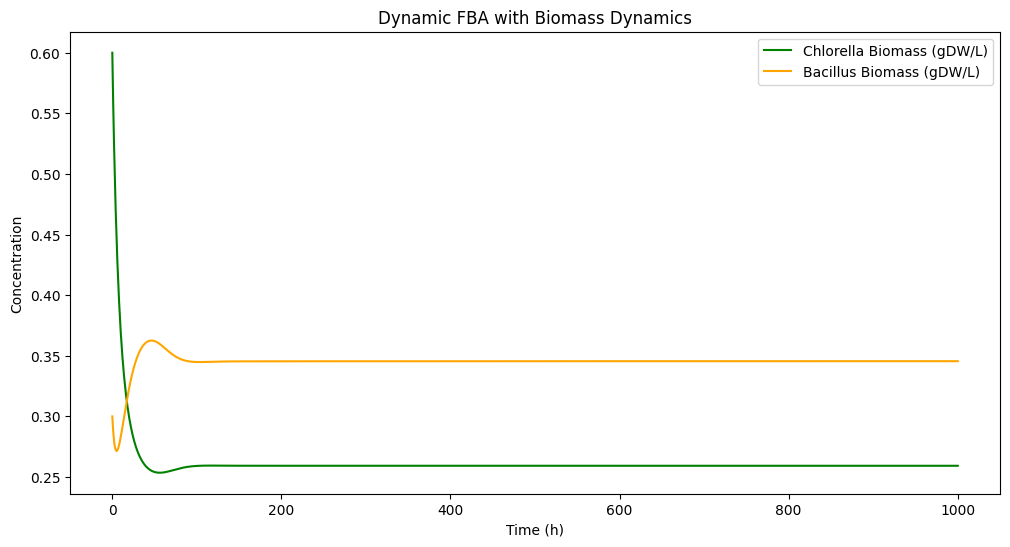

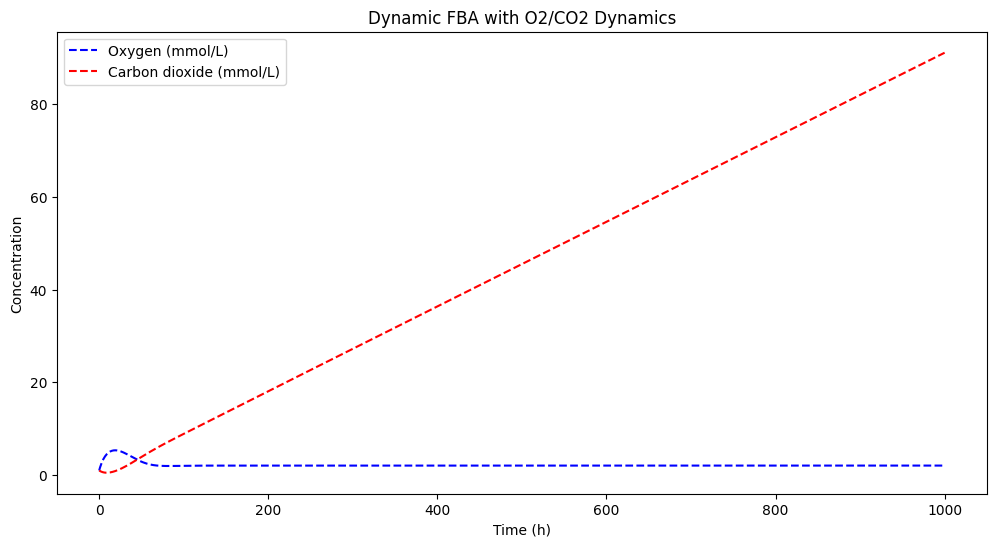

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[0], label='Chlorella Biomass (gDW/L)', color='green')
plt.plot(sol.t, sol.y[1], label='Bacillus Biomass (gDW/L)', color='orange')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with Biomass Dynamics')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(sol.t, sol.y[2], label='Oxygen (mmol/L)', linestyle='--', color='blue')
plt.plot(sol.t, sol.y[3], label='Carbon dioxide (mmol/L)', linestyle='--', color='red')
plt.xlabel('Time (h)')
plt.ylabel('Concentration')
plt.title('Dynamic FBA with O2/CO2 Dynamics')
plt.legend()
plt.show()

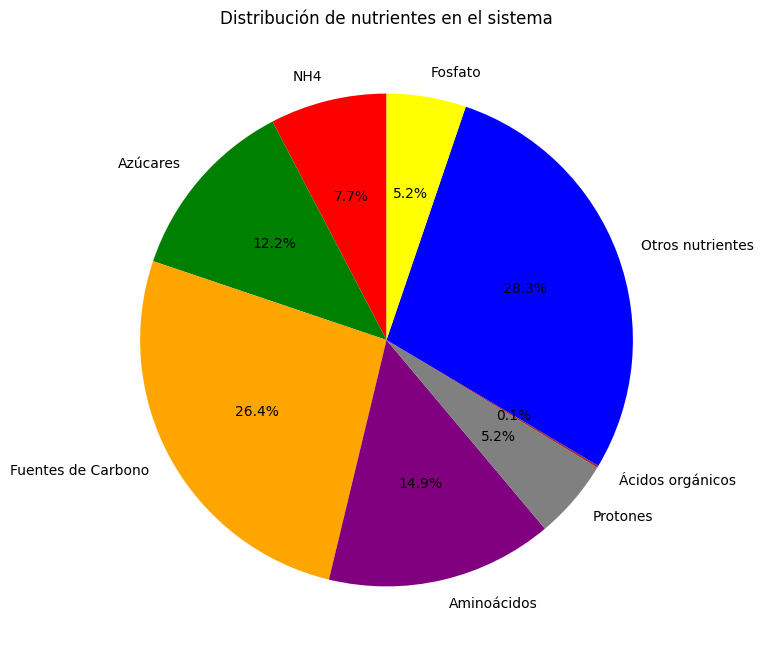

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo: reemplaza estos valores con los resultados finales de tu simulación
# Puedes usar el último valor de cada uno de tus arrays de metabolitos
nutrientes = {
    "NH4": metabolitos_categories["NH4"][-1],
    "Azúcares":  metabolitos_categories["Azúcares"][-1],
    "Fuentes de Carbono": metabolitos_categories["Fuentes_C"][-1],
    "Aminoácidos": metabolitos_categories["Aminoacidos"][-1],
    "Protones": metabolitos_categories["Protones"][-1],
    "Ácidos orgánicos": metabolitos_categories["Acidos orgánicos"][-1],
    "Otros nutrientes": metabolitos_categories["Otros nutrientes"][-1],
    "Fosfato": metabolitos_categories["fosfato"][-1],
}

# Crear el gráfico de pastel
fig, ax = plt.subplots(figsize=(8, 8))
labels = list(nutrientes.keys())
sizes = list(nutrientes.values())

# Colores personalizados
colors = ['red', 'green', 'orange', 'purple', 'grey', 'brown', 'blue', 'yellow', 'cyan', 'pink']

ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Distribución de nutrientes en el sistema')
plt.show()


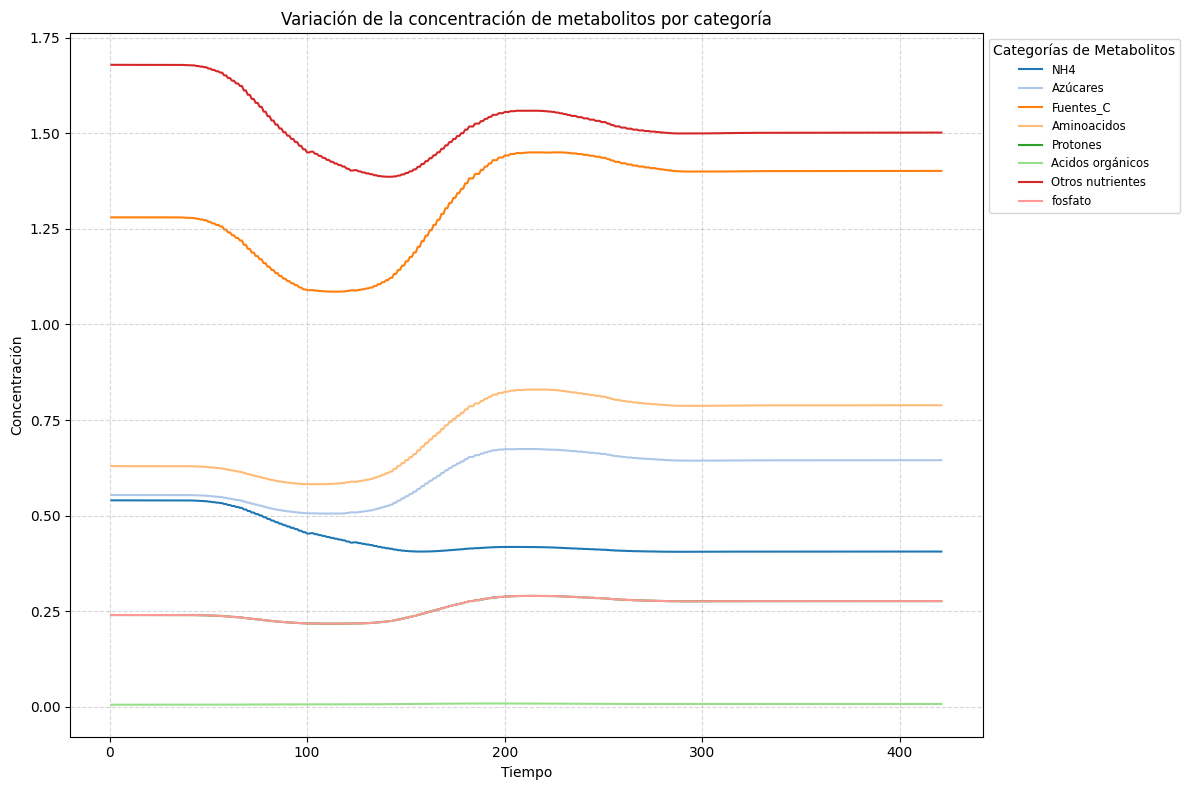

In [30]:
import matplotlib.pyplot as plt
import itertools

def graficar_metabolitos_por_categoria(metabolitos_categories):
    plt.figure(figsize=(12, 8))
    
    # Generar colores únicos para cada categoría
    colores = itertools.cycle(plt.cm.tab20.colors)  # Paleta de 20 colores

    # Graficar cada categoría de metabolitos
    for categoria, concentraciones in metabolitos_categories.items():
        tiempo = list(range(1, len(concentraciones) + 1))
        plt.plot(tiempo, concentraciones, label=f'{categoria}', color=next(colores), linewidth=1.5)
    
    plt.xlabel("Tiempo")
    plt.ylabel("Concentración")
    plt.title("Variación de la concentración de metabolitos por categoría")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Categorías de Metabolitos')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


graficar_metabolitos_por_categoria(metabolitos_categories)



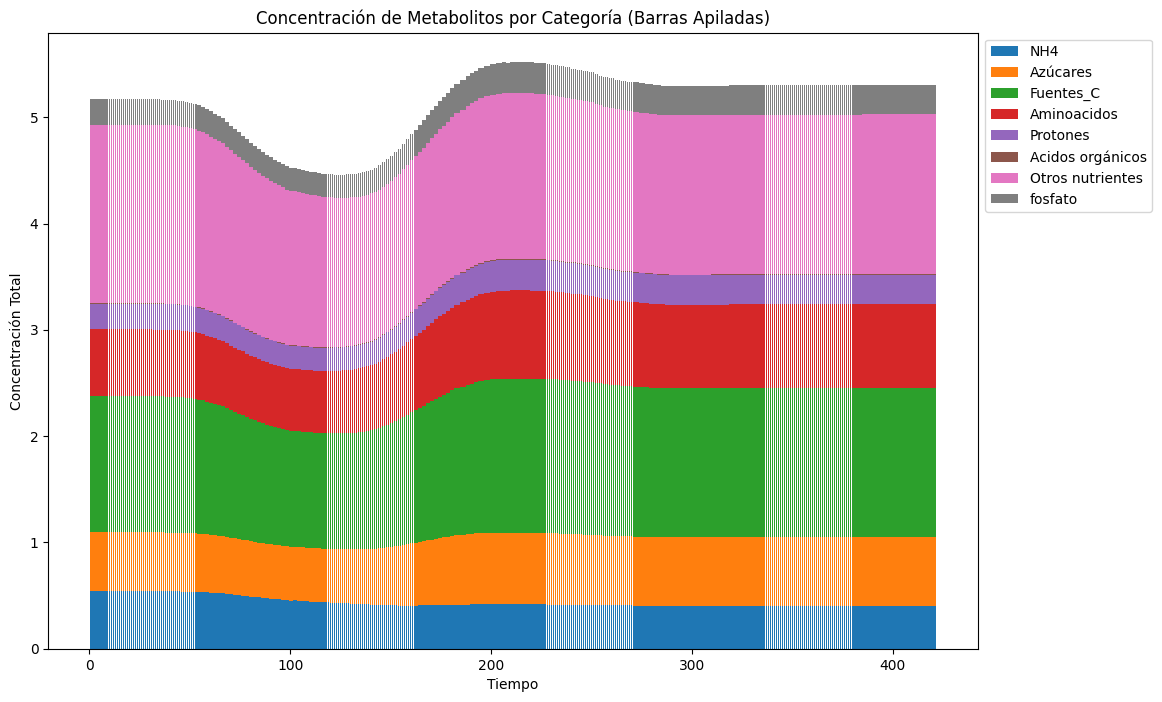

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def grafico_barras_apiladas(metabolitos_categories):
    tiempo = np.arange(1, len(next(iter(metabolitos_categories.values()))) + 1)
    plt.figure(figsize=(12, 8))

    bottom = np.zeros(len(tiempo))
    for categoria, concentraciones in metabolitos_categories.items():
        plt.bar(tiempo, concentraciones, bottom=bottom, label=categoria)
        bottom += np.array(concentraciones)

    plt.xlabel("Tiempo")
    plt.ylabel("Concentración Total")
    plt.title("Concentración de Metabolitos por Categoría (Barras Apiladas)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
grafico_barras_apiladas(metabolitos_categories)

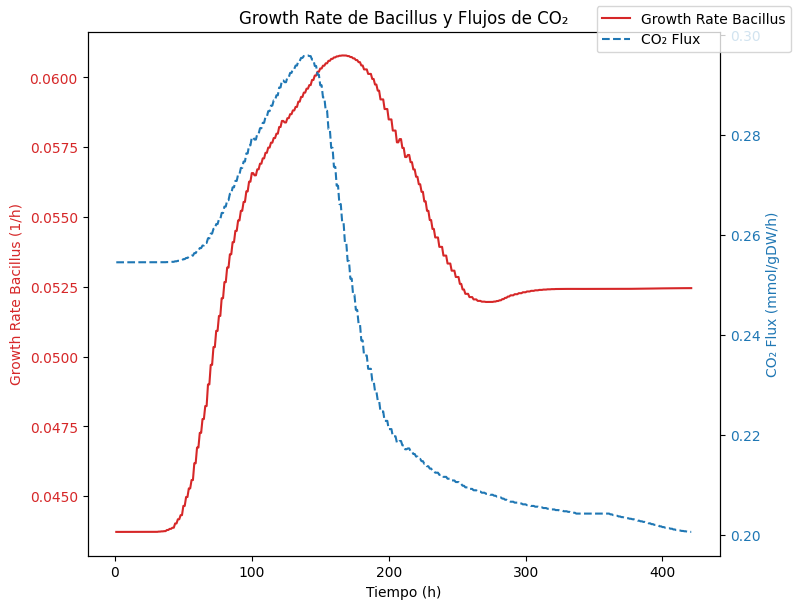

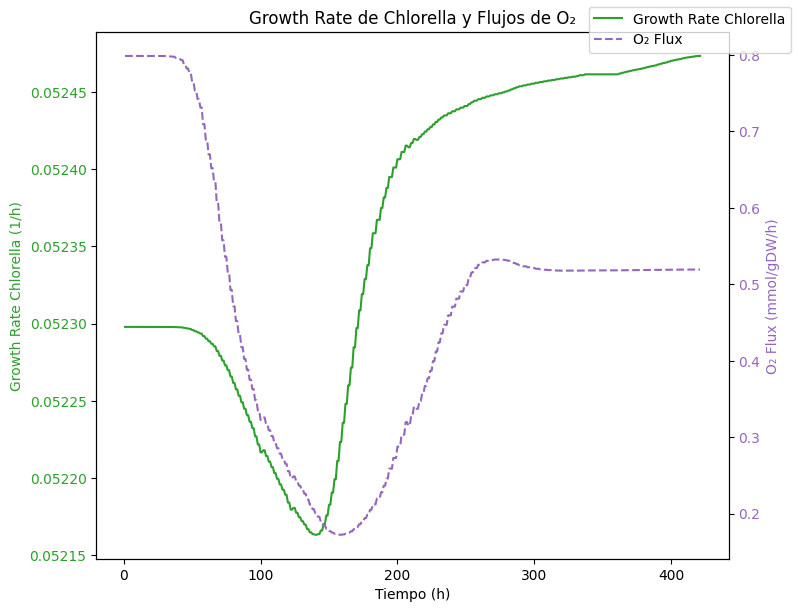

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def grafico_estilo_paper(growth_rates):
    tiempo = np.arange(1, len(growth_rates['bacillus']) + 1)

    # Gráfico 1: Growth Rate de Bacillus y Flujos de CO₂
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:red'
    ax1.set_xlabel('Tiempo (h)')
    ax1.set_ylabel('Growth Rate Bacillus (1/h)', color=color)
    ax1.plot(tiempo, growth_rates['bacillus'], color=color, linestyle='-', label='Growth Rate Bacillus')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('CO₂ Flux (mmol/gDW/h)', color=color)
    ax2.plot(tiempo, growth_rates['CO2'], color=color, linestyle='--', label='CO₂ Flux')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("Growth Rate de Bacillus y Flujos de CO₂")
    fig.legend(loc='upper right')
    plt.show()

    # Gráfico 2: Growth Rate de Chlorella y Flujos de O₂
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:green'
    ax1.set_xlabel('Tiempo (h)')
    ax1.set_ylabel('Growth Rate Chlorella (1/h)', color=color)
    ax1.plot(tiempo, growth_rates['chlorella'], color=color,  linestyle='-', label='Growth Rate Chlorella')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:purple'
    ax2.set_ylabel('O₂ Flux (mmol/gDW/h)', color=color)
    ax2.plot(tiempo, growth_rates['O2'], color=color, linestyle='--', label='O₂ Flux')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("Growth Rate de Chlorella y Flujos de O₂")
    fig.legend(loc='upper right')
    plt.show()



grafico_estilo_paper(growth_rates)



### Sensibiity analysis

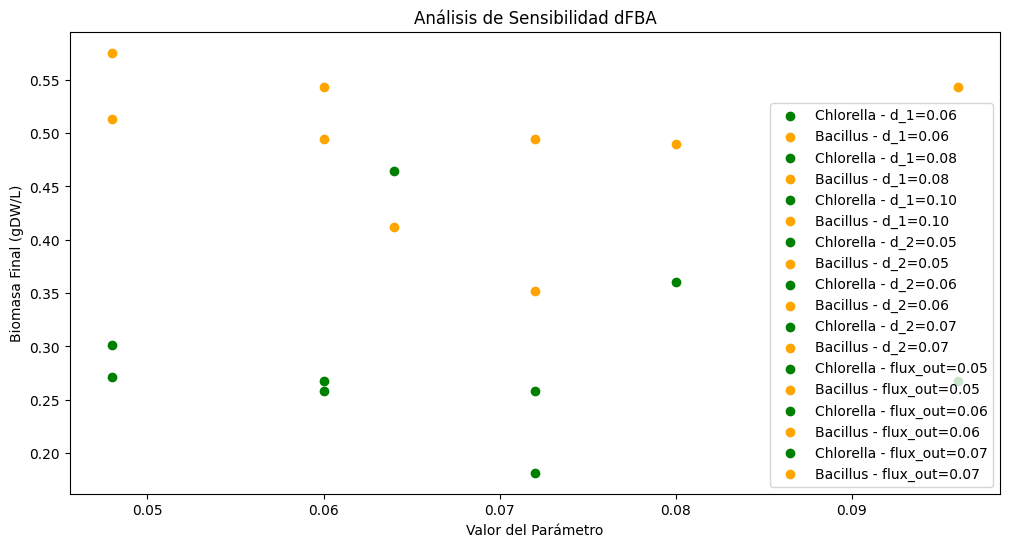

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# Parámetros base
parametros = {
    'd_1': 0.08,  # Tasa de muerte Chlorella
    'd_2': 0.06,  # Tasa de muerte Bacillus
    'flux_out': 0.06,  # Tasa de salida de gases
}

# Rango de variación (±20%)
rango_variacion = 0.2

# Función para obtener los valores de v1, v2, O2 y CO2
def obtener_valores():
    with chlorella:
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]
    with bacillus:
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
    return v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac

# Análisis de sensibilidad
resultados_sensibilidad = {}
for param in parametros:
    valores = [parametros[param] * (1 - rango_variacion), parametros[param], parametros[param] * (1 + rango_variacion)]
    for valor in valores:
        parametros[param] = valor

        # Obtener los valores de v1, v2 y flujos
        v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac = obtener_valores()

        # Resolver dFBA con el parámetro modificado
        def dynamic_system(t, y):
            x1, x2, O2, CO2 = y
            dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * parametros['d_1']
            dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * parametros['d_2']
            O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - parametros['flux_out']
            CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - parametros['flux_out']
            return [dx1_dt, dx2_dt, O2, CO2]

        sol = solve_ivp(dynamic_system, [0, 80], [0.6, 0.3, 1, 1], t_eval=np.linspace(0, 80, 1000), method='BDF')
        resultados_sensibilidad[(param, valor)] = sol.y[0][-1], sol.y[1][-1]  # Biomasa final

# Visualización de resultados
fig, ax = plt.subplots(figsize=(12, 6))
for param, valor in resultados_sensibilidad:
    biomass_chl, biomass_bac = resultados_sensibilidad[(param, valor)]
    ax.scatter(valor, biomass_chl, label=f'Chlorella - {param}={valor:.2f}', color='green')
    ax.scatter(valor, biomass_bac, label=f'Bacillus - {param}={valor:.2f}', color='orange')

ax.set_title('Análisis de Sensibilidad dFBA')
ax.set_xlabel('Valor del Parámetro')
ax.set_ylabel('Biomasa Final (gDW/L)')
ax.legend()
plt.show()



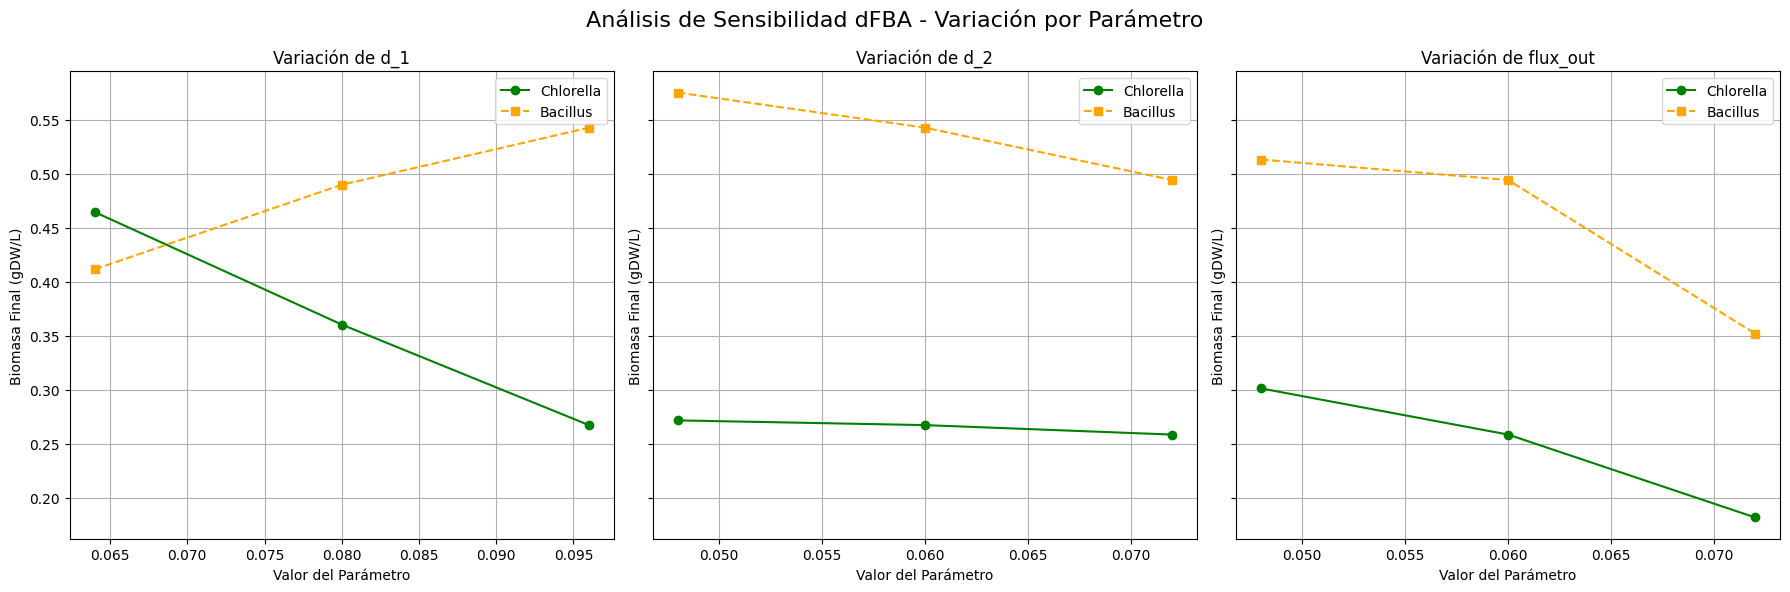

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar el análisis de sensibilidad de manera clara
def graficar_sensibilidad(resultados_sensibilidad):
    parametros = ['d_1', 'd_2', 'flux_out']
    especies = ['Chlorella', 'Bacillus']
    colores = {'Chlorella': 'green', 'Bacillus': 'orange'}

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle('Análisis de Sensibilidad dFBA - Variación por Parámetro', fontsize=16)

    for i, param in enumerate(parametros):
        chl_values = []
        bac_values = []
        x_values = []
        for (p, valor), (biomasa_chl, biomasa_bac) in resultados_sensibilidad.items():
            if p == param:
                x_values.append(valor)
                chl_values.append(biomasa_chl)
                bac_values.append(biomasa_bac)
        # Graficar Chlorella
        axes[i].plot(x_values, chl_values, marker='o', linestyle='-', color=colores['Chlorella'], label='Chlorella')
        # Graficar Bacillus
        axes[i].plot(x_values, bac_values, marker='s', linestyle='--', color=colores['Bacillus'], label='Bacillus')
        axes[i].set_title(f'Variación de {param}')
        axes[i].set_xlabel('Valor del Parámetro')
        axes[i].set_ylabel('Biomasa Final (gDW/L)')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
graficar_sensibilidad(resultados_sensibilidad)

 1. Variación de d_1 (Tasa de Muerte de Chlorella):
Biomasa de Chlorella (verde):

La biomasa de Chlorella disminuye de manera constante y pronunciada a medida que aumenta la tasa de muerte (d_1).

Esto confirma que Chlorella es extremadamente sensible a su propia tasa de mortalidad, especialmente en periodos prolongados (1000 horas).

Biomasa de Bacillus (naranja):

Bacillus permanece prácticamente inalterado ante los cambios en d_1.

Esto significa que la viabilidad de Bacillus no depende directamente de la mortalidad de Chlorella, lo que refuerza su alta robustez en el sistema.

 Conclusión:

El aumento en la tasa de muerte de Chlorella compromete significativamente su biomasa, mientras que Bacillus permanece estable, lo que sugiere que el sistema no es resiliente frente a la vulnerabilidad de Chlorella.

 2. Variación de d_2 (Tasa de Muerte de Bacillus):
Biomasa de Chlorella (verde):

Prácticamente no cambia en función de d_2, lo que indica que la muerte de Bacillus no afecta directamente la viabilidad de Chlorella.

Biomasa de Bacillus (naranja):

La biomasa de Bacillus disminuye gradualmente a medida que aumenta su propia tasa de muerte, aunque no de forma tan drástica como en el caso de Chlorella.

Esto sugiere que Bacillus también es sensible a su propia mortalidad, pero su robustez es mayor en comparación con Chlorella.

 Conclusión:

El sistema muestra que Bacillus tiene una capacidad de sostener su biomasa incluso cuando aumenta su tasa de muerte, lo que refleja su capacidad de adaptación o su eficiencia metabólica.

 3. Variación de flux_out (Tasa de Salida de Gases):
Biomasa de Chlorella (verde):

La biomasa disminuye ligeramente conforme aumenta el flujo de salida.

Esto sugiere que Chlorella depende en cierta medida de la retención de gases (O₂ y CO₂), aunque el impacto no es tan dramático como con la tasa de muerte.

Biomasa de Bacillus (naranja):

La biomasa de Bacillus también disminuye a medida que aumenta el flujo de salida, aunque de forma más progresiva y menos pronunciada que Chlorella.

 Conclusión:

El parámetro flux_out tiene un impacto en ambas especies, pero el sistema sigue siendo más sensible a las tasas de mortalidad.  

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
from tqdm import tqdm

# =========================
# 1. Análisis de Sensibilidad Global (Sobol)
# =========================

# Definición del problema para Sobol
problem = {
    'num_vars': 3,
    'names': ['d_1', 'd_2', 'flux_out'],
    'bounds': [[0.04, 0.12], [0.04, 0.08], [0.05, 0.07]]
}

# Muestras para Sobol
param_values = saltelli.sample(problem, 1000)

# Función objetivo (evaluación del modelo)
def modelo_sobol(params):
    d_1, d_2, flux_out = params
    # Simulación dinámica
    def dynamic_system(t, y):
        x1, x2, O2, CO2 = y
        dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * d_1
        dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * d_2
        O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - flux_out
        CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - flux_out
        return [dx1_dt, dx2_dt, O2, CO2]
    sol = solve_ivp(dynamic_system, [0, 1000], [0.6, 0.3, 1, 1], t_eval=np.linspace(0, 1000, 1000), method='BDF')
    return sol.y[0][-1], sol.y[1][-1]

# Ejecución del análisis de sensibilidad global
Y = np.array([modelo_sobol(params) for params in tqdm(param_values)])
Si = sobol.analyze(problem, Y[:, 0])  # Biomasa de Chlorella
print('Sensibilidad Global (Chlorella):', Si)
Si = sobol.analyze(problem, Y[:, 1])  # Biomasa de Bacillus
print('Sensibilidad Global (Bacillus):', Si)


C:\Users\elena\AppData\Local\Temp\ipykernel_19928\1272161431.py:20: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)
C:\Users\elena\anaconda3\envs\nuevo_entorno\lib\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
100%|██████████| 8000/8000 [03:30<00:00, 38.01it/s]

Sensibilidad Global (Chlorella): {'S1': array([ 0.16072556, -0.00168464,  0.0008548 ]), 'S1_conf': array([0.11852595, 0.06982107, 0.05331542]), 'ST': array([1.01417941, 0.6708688 , 0.55484591]), 'ST_conf': array([0.13527231, 0.12935038, 0.10610661]), 'S2': array([[        nan,  0.20139161,  0.15174861],
       [        nan,         nan, -0.01010031],
       [        nan,         nan,         nan]]), 'S2_conf': array([[       nan, 0.17727508, 0.15304098],
       [       nan,        nan, 0.07688562],
       [       nan,        nan,        nan]])}
Sensibilidad Global (Bacillus): {'S1': array([0.15507103, 0.02639137, 0.0134207 ]), 'S1_conf': array([0.11812936, 0.064592  , 0.05056575]), 'ST': array([0.96411529, 0.76559367, 0.6142984 ]), 'ST_conf': array([0.21026975, 0.18133026, 0.17195146]), 'S2': array([[       nan, 0.17917687, 0.11296946],
       [       nan,        nan, 0.02937013],
       [       nan,        nan,        nan]]), 'S2_conf': array([[       nan, 0.20181825, 0.20253972],
   


C:\Users\elena\anaconda3\envs\nuevo_entorno\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))



Resultados para Chlorella
Sensibilidad de Primer Orden (S1)
d_1 (Tasa de Muerte de Chlorella):

S1 = 0.1607 ± 0.1048

Esto indica que el 16% de la variación en la biomasa de Chlorella se debe directamente a este parámetro.

d_2 (Tasa de Muerte de Bacillus):

S1 = -0.0017 ± 0.0634

Valor cercano a 0, indicando que no tiene prácticamente efecto directo.

flux_out (Flujo de salida de gases):

S1 = 0.0008 ± 0.0589

Valor muy bajo, lo que significa que su efecto directo también es despreciable.

Sensibilidad Total (ST)
d_1: ST = 1.0141 ± 0.1653

El hecho de que sea cercano a 1 implica que d_1 es el parámetro que más influye, ya sea directa o indirectamente.

d_2: ST = 0.6708 ± 0.1352

Tiene un impacto significativo, aunque no tan fuerte como d_1.

flux_out: ST = 0.5548 ± 0.1101

También tiene cierta influencia combinada con otros parámetros.

Sensibilidad de Segundo Orden (S2)
d_1 y d_2: S2 = 0.2014 ± 0.1567

Existe cierta interacción entre ambos parámetros.

d_1 y flux_out: S2 = 0.1517 ± 0.1616

También se observa una leve interacción entre la tasa de muerte de Chlorella y la salida de gases.
 Resultados para Bacillus
 Sensibilidad de Primer Orden (S1)
d_1: S1 = 0.1551 ± 0.1155

La mortalidad de Chlorella tiene un pequeño efecto directo sobre la biomasa de Bacillus.

d_2: S1 = 0.0264 ± 0.0604

El efecto directo es muy bajo, lo que indica que Bacillus es más robusto frente a su propia mortalidad.

flux_out: S1 = 0.0134 ± 0.0494

Casi nulo, lo que sugiere que la tasa de salida de gases tiene poco impacto directo en Bacillus.

 Sensibilidad Total (ST)
d_1: ST = 0.9641 ± 0.1836

Esto indica que el parámetro d_1 influye fuertemente en Bacillus, pero de manera indirecta, probablemente debido a la disminución de competencia cuando Chlorella muere.

d_2: ST = 0.7656 ± 0.1764

El impacto combinado también es significativo.

flux_out: ST = 0.6143 ± 0.1565

Aunque bajo, muestra cierta influencia cuando se combina con otros parámetros.

Sensibilidad de Segundo Orden (S2)
d_1 y d_2: S2 = 0.1792 ± 0.2095

Los dos parámetros de mortalidad pueden influir juntos en la biomasa de Bacillus.

d_1 y flux_out: S2 = 0.1130 ± 0.2000

La combinación de la mortalidad de Chlorella y la salida de gases también muestra un pequeño impacto conjunto.



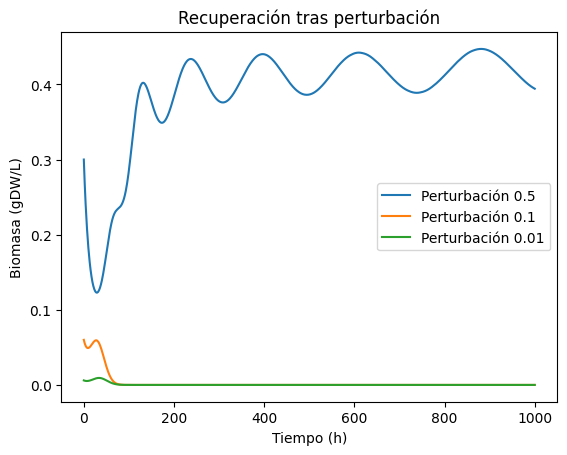

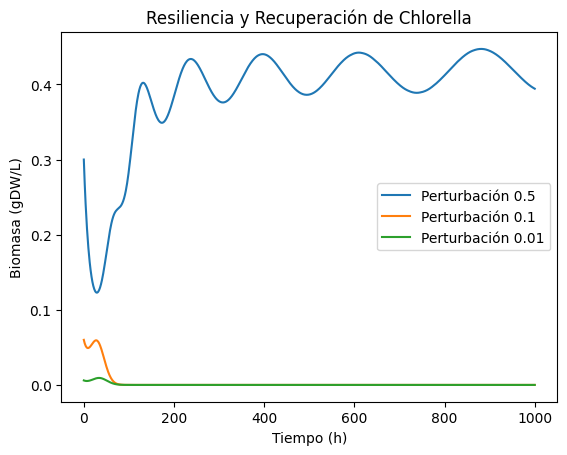

Tiempos de Recuperación: [np.int64(0), np.int64(0), np.int64(0)]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
from tqdm import tqdm

# =========================
# Función para obtener valores metabólicos
# =========================
def obtener_valores():
    with chlorella:
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]
    with bacillus:
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
    return v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac

# =========================
# Obtener valores iniciales
# =========================
v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac = obtener_valores()

# =========================
# Análisis de Perturbación Dinámica
# =========================
perturbaciones = [0.5, 0.1, 0.01]  # Disminución drástica de la biomasa
d_1, d_2, flux_out = 0.08, 0.06, 0.06

for factor in perturbaciones:
    def dynamic_system_pert(t, y):
        x1, x2, O2, CO2 = y
        dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * d_1
        dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * d_2
        O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - flux_out
        CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - flux_out
        return [dx1_dt, dx2_dt, O2, CO2]
    sol = solve_ivp(dynamic_system_pert, [0, 1000], [0.6 * factor, 0.3, 1, 1], t_eval=np.linspace(0, 1000, 1000), method='BDF')
    plt.plot(sol.t, sol.y[0], label=f'Perturbación {factor}')
plt.title('Recuperación tras perturbación')
plt.xlabel('Tiempo (h)')
plt.ylabel('Biomasa (gDW/L)')
plt.legend()
plt.show()

# =========================
# Análisis de Resiliencia y Recuperación
# =========================
tiempos_recuperacion = []
for factor in perturbaciones:
    def dynamic_system_recover(t, y):
        x1, x2, O2, CO2 = y
        dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * d_1
        dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * d_2
        O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - flux_out
        CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - flux_out
        return [dx1_dt, dx2_dt, O2, CO2]
    sol = solve_ivp(dynamic_system_recover, [0, 1000], [0.6 * factor, 0.3, 1, 1], t_eval=np.linspace(0, 1000, 1000), method='BDF')
    tiempo_recuperacion = np.argmax(sol.y[0] > 0.6)
    tiempos_recuperacion.append(tiempo_recuperacion)
    plt.plot(sol.t, sol.y[0], label=f'Perturbación {factor}')
plt.title('Resiliencia y Recuperación de Chlorella')
plt.xlabel('Tiempo (h)')
plt.ylabel('Biomasa (gDW/L)')
plt.legend()
plt.show()

print('Tiempos de Recuperación:', tiempos_recuperacion)


Chlorella es la especie más vulnerable del sistema, mientras que Bacillus ha mostrado ser altamente robusto en otros análisis.

Si el sistema colapsa debido a la pérdida de Chlorella, no tiene sentido verificar la resiliencia de Bacillus ya que se mantiene estable casi siempre.

Sin embargo, sí se puede hacer para Bacillus para analizar su comportamiento en caso de perturbaciones específicas o cuando se busque comparar la respuesta de ambas especies.                                                                                                                       En el código actual, las perturbaciones se aplican multiplicando la biomasa inicial por un factor de reducción. Es decir:

Una perturbación de 0.5 significa que la biomasa inicial se reduce a la mitad.

Una perturbación de 0.1 significa que la biomasa inicial se reduce al 10% de su valor original.

Una perturbación de 0.01 significa que la biomasa inicial se reduce al 1% de su valor original 

Este gráfico muestra cómo responde el sistema después de aplicar perturbaciones de distinta magnitud a la biomasa de Chlorella:

Perturbación 0.5 (línea azul):

La biomasa de Chlorella cae bruscamente hasta un nivel muy bajo.

Después de aproximadamente 50 horas, comienza una recuperación progresiva.

A lo largo del tiempo, la biomasa presenta un comportamiento oscilante pero logra estabilizarse en torno a un valor cercano a 0.4 gDW/L.

Esto muestra que el sistema es resiliente ante perturbaciones moderadas, aunque con cierta inestabilidad temporal.

Perturbación 0.1 (línea naranja):

La biomasa cae bruscamente y no se recupera, permaneciendo en niveles prácticamente nulos.

Esto sugiere que una perturbación severa provoca el colapso completo de Chlorella.

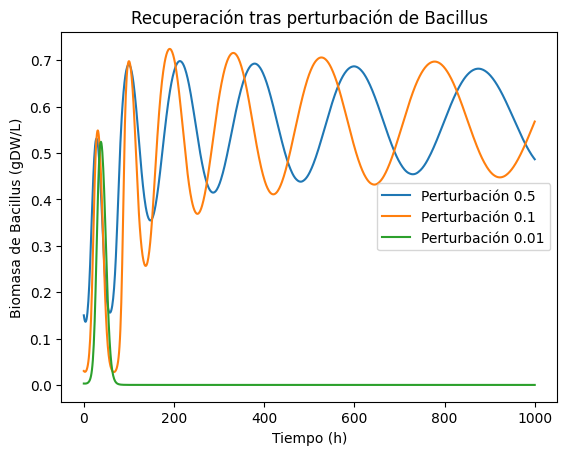

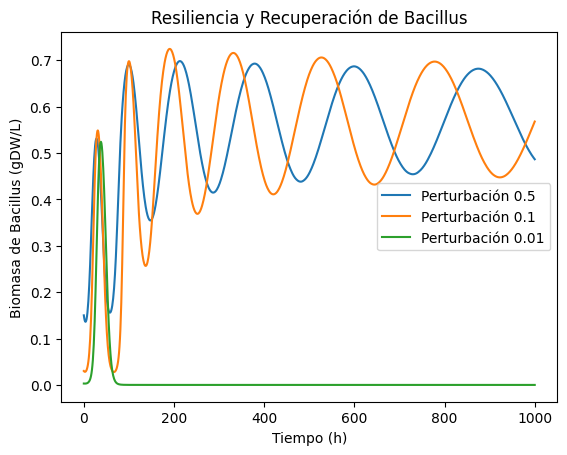

Tiempos de Recuperación de Bacillus: [np.int64(16), np.int64(21), np.int64(29)]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli
from SALib.analyze import sobol
from tqdm import tqdm

# =========================
# Función para obtener valores metabólicos
# =========================
def obtener_valores():
    with chlorella:
        sol_chl = chlorella.optimize()
        v1 = sol_chl.fluxes[chlorella_biomass_rxn]
        flux_o2_chl = sol_chl.fluxes[chlorella_o2_exchange]
        flux_co2_chl = sol_chl.fluxes["EX_co2_LPAREN_e_RPAREN_"]
    with bacillus:
        sol_bac = bacillus.optimize()
        v2 = sol_bac.fluxes[bacillus_biomass_rxn]
        flux_o2_bac = sol_bac.fluxes[bacillus_o2_exchange]
        flux_co2_bac = sol_bac.fluxes["EX_co2_e"]
    return v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac

# =========================
# Obtener valores iniciales
# =========================
v1, v2, flux_o2_chl, flux_o2_bac, flux_co2_chl, flux_co2_bac = obtener_valores()
d_1, d_2, flux_out = 0.08, 0.06, 0.06

# =========================
# Análisis de Perturbación Dinámica para Bacillus
# =========================
perturbaciones = [0.5, 0.1, 0.01]  # Factores de reducción de biomasa

for factor in perturbaciones:
    def dynamic_system_pert_bacillus(t, y):
        x1, x2, O2, CO2 = y
        dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * d_1
        dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * d_2
        O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - flux_out
        CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - flux_out
        return [dx1_dt, dx2_dt, O2, CO2]
    sol = solve_ivp(dynamic_system_pert_bacillus, [0, 1000], [0.6, 0.3 * factor, 1, 1], t_eval=np.linspace(0, 1000, 1000), method='BDF')
    plt.plot(sol.t, sol.y[1], label=f'Perturbación {factor}')
plt.title('Recuperación tras perturbación de Bacillus')
plt.xlabel('Tiempo (h)')
plt.ylabel('Biomasa de Bacillus (gDW/L)')
plt.legend()
plt.show()

# =========================
# Análisis de Resiliencia y Recuperación para Bacillus
# =========================
tiempos_recuperacion_bacillus = []
for factor in perturbaciones:
    def dynamic_system_recover_bacillus(t, y):
        x1, x2, O2, CO2 = y
        dx1_dt = x1 * v1 * CO2 * (1 - x1 - x2) - x1 * d_1
        dx2_dt = x2 * v2 * O2 * (1 - x1 - x2) - x2 * d_2
        O2 = flux_o2_chl * x1 + flux_o2_bac * x2 - flux_out
        CO2 = flux_co2_chl * x1 + flux_co2_bac * x2 - flux_out
        return [dx1_dt, dx2_dt, O2, CO2]
    sol = solve_ivp(dynamic_system_recover_bacillus, [0, 1000], [0.6, 0.3 * factor, 1, 1], t_eval=np.linspace(0, 1000, 1000), method='BDF')
    tiempo_recuperacion = np.argmax(sol.y[1] > 0.3)
    tiempos_recuperacion_bacillus.append(tiempo_recuperacion)
    plt.plot(sol.t, sol.y[1], label=f'Perturbación {factor}')
plt.title('Resiliencia y Recuperación de Bacillus')
plt.xlabel('Tiempo (h)')
plt.ylabel('Biomasa de Bacillus (gDW/L)')
plt.legend()
plt.show()

print('Tiempos de Recuperación de Bacillus:', tiempos_recuperacion_bacillus)
